# Set-Up

In [10]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [11]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from itertools import groupby
from PIL import ImageFont
import os
import cv2
from tqdm import trange, tqdm
import random
import matplotlib.pyplot as plt
import math

#from modules.dataset import generate_sample
from loss import ctc_loss_log_differentiable_torch
from dataset import safe_convert_to_grayscale


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, pool_ksize=(2, 2)):
        super(ConvBlock, self).__init__()

        self.block = nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, padding=1),
                                   nn.LeakyReLU(0.1),
                                   nn.BatchNorm2d(out_channels),
                                   nn.MaxPool2d(pool_ksize))

    def forward(self, x):
        return self.block(x)


class ResidualConvBlock2d(nn.Module):
    def __init__(self, in_channels, out_channels, pool_ksize=(2, 2)):
        super(ResidualConvBlock2d, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.pool = nn.MaxPool2d(pool_ksize)
        self.lrelu = nn.LeakyReLU(0.1)

        self.identity_conv = nn.Conv2d(in_channels, out_channels, 1, stride=pool_ksize)

    def forward(self, x):
        e = self.conv1(x)
        e = self.lrelu(e)
        e = self.bn1(e)
        e = self.conv2(e)
        e = self.lrelu(e)
        e = self.bn2(e)
        
        e = self.pool(e)
        
        return self.identity_conv(x) + e


class ResidualConvBlock1d(nn.Module):
    def __init__(self, in_channels, out_channels, pool_ksize=2):
        super(ResidualConvBlock1d, self).__init__()

        self.conv1 = nn.Conv1d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv1d(out_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.pool = nn.MaxPool1d(pool_ksize)
        self.lrelu = nn.LeakyReLU(0.1)

        self.identity_conv = nn.Conv1d(in_channels, out_channels, 1, stride=pool_ksize)

    def forward(self, x):
        e = self.conv1(x)
        e = self.lrelu(e)
        e = self.bn1(e)
        e = self.conv2(e)
        e = self.lrelu(e)
        e = self.bn2(e)
        e = self.pool(e)

        return self.identity_conv(x) + e


class ScriptClassificationModel(nn.Module):
    def __init__(self, nscripts, input_shape):
        super(ScriptClassificationModel, self).__init__()

        self.feature_extractor = nn.Sequential(nn.Conv1d(input_shape[0], input_shape[0]//2, 4),
                                               nn.LeakyReLU(0.1),
                                               nn.BatchNorm1d(input_shape[0]//2),
                                               nn.MaxPool1d(4),
                                              
                                               nn.Conv1d(input_shape[0]//2, input_shape[0]//4, 4),
                                               nn.LeakyReLU(0.1),
                                               nn.BatchNorm1d(input_shape[0]//4),
                                               nn.MaxPool1d(4))

        self.feature_extractor = nn.Sequential(ResidualConvBlock1d(input_shape[0], input_shape[0], 2),
                                               ResidualConvBlock1d(input_shape[0], input_shape[0]//2, 2),
                                               ResidualConvBlock1d(input_shape[0]//2, input_shape[0]//2, 2),
                                               ResidualConvBlock1d(input_shape[0]//2, input_shape[0]//4, 2),
                                               ResidualConvBlock1d(input_shape[0]//4, input_shape[0]//4, 2))

        self.fc = nn.Sequential(nn.Linear(64, nscripts),
                                nn.Softmax(dim=-1))

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view((x.shape[0], -1))

        x = self.fc(x)

        return x


class RecognitionHead(nn.Module):
    def __init__(self, alphabet_len):
        super(RecognitionHead, self).__init__()
        
        self.rnn1 = nn.RNN(256, 256, batch_first=True)
        self.rnn2 = nn.RNN(256, 256, batch_first=True)

        self.fc = nn.Sequential(nn.Linear(256, 128),
                                nn.ReLU(),
                                nn.Linear(128, alphabet_len+1),
                                nn.Softmax(dim=2))

    def forward(self, x):
        x = torch.permute(x, (0, 2, 1))
        
        x, _ = self.rnn1(x, None)
        x, _ = self.rnn2(x, None)
        x = self.fc(x)

        return x


class MCRNN(nn.Module):
    def __init__(self, alphabet_lens):
        super(MCRNN, self).__init__()

        self.feature_extractor = nn.Sequential(ResidualConvBlock2d(1, 16),
                                               ResidualConvBlock2d(16, 32, (2, 1)),
                                               ResidualConvBlock2d(32, 64),
                                               ResidualConvBlock2d(64, 128),
                                               ResidualConvBlock2d(128, 256, (2, 1)))

        self.script_classifier = ScriptClassificationModel(len(alphabet_lens), (256, 32))

        self.recognition_heads = nn.ModuleList([RecognitionHead(max(alphabet_lens)) for _ in alphabet_lens])

        self.output_dim = max(alphabet_lens) + 1

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, x):
        x = self.feature_extractor(x).squeeze(2)

        script_probs = self.script_classifier(x)
        script_indices = script_probs.argmax(-1)
        
        output = torch.zeros((x.shape[0], x.shape[2], self.output_dim), device=self.device)

        for sidx in torch.unique(script_indices):
            output[script_indices == sidx] = self.recognition_heads[sidx](x[script_indices == sidx])

        return output, script_probs


class my_OCRDataset(Dataset):
    def __init__(self, segments_list, output_shape, script_alphabets, batch_size, num_steps, fonts_path='./fonts', bgs_path='./backgrounds'):
        super(Dataset, self).__init__()

        self.segments_list = segments_list
        self.batch_size = batch_size
        self.num_steps = num_steps
        self.output_shape = output_shape
        self.script_alphabets = script_alphabets

        self.fonts_path = fonts_path
        #self.bgs = [cv2.imread(os.path.join(bgs_path, fn), cv2.IMREAD_GRAYSCALE) for fn in os.listdir(bgs_path)]
    
    def encode_text(self, text, alphabet_idx, seq_len, blank_idx=0):
        def _label_to_num(label):
            label_num = []
            for ch in label:
                idx = alphabet.find(ch)
                label_num.append(idx + (idx >= blank_idx))
            return np.array(label_num)

        alphabet = self.script_alphabets[alphabet_idx]
        if blank_idx < 0:
            blank_idx = len(alphabet)
        nums = np.full((seq_len,), fill_value=blank_idx, dtype='int32')
        nums[:len(text)] = _label_to_num(text)
    
        return nums
    
    
    def decode_target(self, nums, alphabet_idx, blank_idx=0):
        alphabet = self.script_alphabets[alphabet_idx]
        
        if blank_idx < 0:
            blank_idx = len(alphabet)
        nums_collapsed = [alphabet[idx-(idx >= blank_idx)] for idx in nums.cpu().detach().numpy() if idx != blank_idx]
        return ''.join(nums_collapsed)

    def decode_pred(self, logits, alphabet_idx, blank_idx=0):
        alphabet = self.script_alphabets[alphabet_idx]
        
        if blank_idx < 0:
            blank_idx = len(alphabet)

        nums = torch.argmax(logits, dim=-1)
        nums_collapsed = [alphabet[idx-(idx >= blank_idx)] for idx, _ in groupby(nums.cpu().detach().numpy()) if idx != blank_idx and idx < len(alphabet)]
        return ''.join(nums_collapsed)
        
    def __len__(self):
        #return self.batch_size * self.num_steps
        return len(self.segments_list)

    def __getitem__(self, idx):
        #script_idx = random.randint(0, len(self.script_alphabets)-1)
        #image, text = generate_sample(output_shape=self.output_shape, alphabet=self.script_alphabets[script_idx], 
        #                              seq_len=(3, 25), bgs=self.bgs, fonts_path=self.fonts_path)
        script_idx = self.segments_list[idx][2]
        image, text = self.segments_list[idx][0], self.segments_list[idx][1]
        image = torch.FloatTensor(image / 255).unsqueeze(0)
        target = torch.IntTensor(self.encode_text(text, script_idx, 32))

        return image, target, script_idx

def multilingual_loss(log_logits: torch.FloatTensor, targets: torch.LongTensor, device, script_probs, script_targets, decoded_target):
    ctc_loss_values = torch.zeros((log_logits.shape[0],), device=device)
        
    for idx in torch.unique(script_targets):
        script_log_logits = log_logits[script_targets == idx]
        
        targets_ = targets[script_targets == idx]

        input_lengths = torch.full((script_log_logits.shape[0],), script_log_logits.shape[1]).to(device)
        target_lengths = torch.sum(targets_ != 0, axis=1)
            
        ctc_loss_values[script_targets == idx] = ctc_loss_log_differentiable_torch(torch.log(script_log_logits), targets_, input_lengths, target_lengths, device, reduction='none')

    ctc_loss_values[script_targets != script_probs.argmax(-1)] = 0

    script_loss_value = F.cross_entropy(script_probs, script_targets, reduction='none')
    alpha_mask = torch.BoolTensor([any(c.isalpha() for c in s) for s in decoded_target])

    if script_loss_value[alpha_mask].shape[0] == 0:
        script_loss_value = torch.FloatTensor([0]).to(device)
    else:
        script_loss_value = torch.mean(script_loss_value[alpha_mask])

    return ctc_loss_values.mean(), script_loss_value

def prepare_segment_for_recognition(segment, target_shape=(32, 256)):
    segment = safe_convert_to_grayscale(segment)
    
    coef = min(target_shape[0] / segment.shape[0], target_shape[1] / segment.shape[1])

    segment = cv2.resize(segment, dsize=None, fx=coef, fy=coef, interpolation=cv2.INTER_AREA if coef < 1 else cv2.INTER_CUBIC)
    left = target_shape[1]-segment.shape[1]
    top = target_shape[0]-segment.shape[0]
    if top > 0:
        segment = cv2.copyMakeBorder(segment, 0, top, 0, left, cv2.BORDER_CONSTANT, value=(255, 255, 255))
    else: 
        segment = cv2.copyMakeBorder(segment, 0, top, 0, left, cv2.BORDER_CONSTANT, value=(114, 114, 114))
    
    return segment


# Dataset Prep

In [12]:
from pathlib import Path
from PIL import Image, ImageOps
import json

annotation_path = Path('/home/vshishaev/layout_all/fixed_receipts_2506.json')

with open(annotation_path, 'r') as annotation_f:
  annotation_list = json.load(annotation_f)


def load_numpy_image(image_path):
    pil_im = Image.open(image_path)        
    pil_im = ImageOps.exif_transpose(pil_im)
    pil_im = pil_im.convert('RGB')
      
    image_np = np.array(pil_im, dtype=np.uint8)
    if image_np.shape[2] == 4:
        image_np = cv2.cvtColor(image_np, cv2.COLOR_BGRA2GRAY)
    elif image_np.shape[2] == 3:
        image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

    return image_np


def unnormalize_box(result):
  value = result['value']
  w, h = result['original_width'], result['original_height']

  if all([key in value for key in ['x', 'y', 'width', 'height']]):
    x0, y0 = w * value['x'] / 100.0, h * value['y'] / 100.0
    x1, y1 = x0 + w * value['width'] / 100.0, y0 + h * value['height'] / 100.0
    return [x0, y0, x1, y1]

# gets formatted data from ls json file for 1 task
#ex = {image: [...], words: [...], boxes: [...], ner_tags: [...]}


def format_ls_anns(receipt_ann, ds_path):
  formatted_ex = {}

  image_name = receipt_ann['data']['ocr'].split('%5C')[1]

  if os.path.exists(os.path.join(ds_path, image_name)):
      
    formatted_ex['image_name'] = image_name  
    
    formatted_ex['image'] = load_numpy_image(os.path.join(ds_path, image_name))

    formatted_ex['words'] = [ann['value']['text'] for ann in receipt_ann['annotations'][0]['result'] if ann['type'] == 'textarea']
    formatted_ex['words'] = np.squeeze(np.array(formatted_ex['words']))

    formatted_ex['boxes'] = np.array([unnormalize_box(ann) for ann in receipt_ann['annotations'][0]['result'] if ann['type'] == 'rectangle'], dtype=np.uint32)

    return formatted_ex
      
  else:
    # print(image_name)
    return None


train_dataset_path = Path('/home/vshishaev/layout_all/train_split')
val_dataset_path = Path('/home/vshishaev/layout_all/val_split')

train_dataset = []
val_dataset = []

for ann in annotation_list:
    example = format_ls_anns(ann, ds_path=train_dataset_path)
    if example is not None:
        train_dataset.append(example)

for ann in annotation_list:
    example = format_ls_anns(ann, ds_path=val_dataset_path)
    if example is not None:
        val_dataset.append(example)

In [13]:
# sroie segments preparation

def order_boxes(boxes):
    def contour_dist(box1, box2):
        def axiswise_dist(s1, s2):
            """
            s = (left coord, right coord)
            """
            left = min(s1, s2, key=lambda x: x[0])
            right = max(s1, s2, key=lambda x: x[0])

            return max(0, right[0] - left[1])

        delta_x = axiswise_dist((box1[0], box1[0] + box1[2]), (box2[0], box2[0] + box2[2]))
        delta_y = axiswise_dist((box1[1], box1[1] + box1[3]), (box2[1], box2[1] + box2[3]))

        if delta_x == delta_y == 0:
            return 0
        if min(delta_x, delta_y) == 0 and max(delta_x, delta_y) > 0:
            return max(delta_x, delta_y)
        return math.sqrt(delta_x * delta_x + delta_y * delta_y)

    y_sorted_boxes = np.array(sorted(boxes.copy(), key=lambda x: x[1]), dtype='int64')
    indices = np.array([i for i, box in sorted(enumerate(boxes.copy()), key=lambda x:x[1][1])])

    epsilon = np.mean(boxes[:, 3])

    cluster_labels = np.full((len(y_sorted_boxes, )), fill_value=-1)

    cluster_labels[0] = 0

    for i in range(len(y_sorted_boxes)):
        if cluster_labels[i] == -1:
            cluster_labels[i] = max(cluster_labels) + 1
        for j in range(len(y_sorted_boxes)):
            if contour_dist(y_sorted_boxes[i], y_sorted_boxes[j]) < epsilon:
                min_l = min(cluster_labels[i], cluster_labels[j])
                max_l = max(cluster_labels[i], cluster_labels[j])
                if min_l == -1:
                    cluster_labels[i] = max_l
                    cluster_labels[j] = max_l
                    continue
                cluster_labels[cluster_labels == max_l] = min_l

    cluster_labels = np.array(cluster_labels)

    sorted_boxes = list()
    sorted_indices = list()
    for c in np.unique(cluster_labels):
        cluster_boxes = y_sorted_boxes[cluster_labels == c]
        cluster_indices = indices[cluster_labels == c]
        
        group = [cluster_boxes[0]]
        indices_group = [cluster_indices[0]]
        for i in range(1, len(cluster_boxes)):
            if abs(cluster_boxes[i][1] - cluster_boxes[i - 1][1]) < (epsilon*0.5):
                group.append(cluster_boxes[i])
                indices_group.append(cluster_indices[i])
            else:
                sorted_boxes.extend(sorted(group, key=lambda x: x[0]))
                sorted_indices.extend([indices_group[i] for i, box in sorted(enumerate(group), key=lambda x: x[1][0])])
                
                group = [cluster_boxes[i]]
                indices_group = [cluster_indices[i]]
                
        sorted_boxes.extend(sorted(group, key=lambda x: x[0]))
        sorted_indices.extend([indices_group[i] for i, box in sorted(enumerate(group), key=lambda x: x[1][0])])

    sorted_boxes = np.array([np.array(box) for box in sorted_boxes])
    return np.array(sorted_indices), sorted_boxes


def generate_examples(filepath):
    ann_dir = os.path.join(filepath, "tagged")
    img_dir = os.path.join(filepath, "images")
    for guid, fname in enumerate(sorted(os.listdir(img_dir))):
        formatted_data = {}
        name, ext = os.path.splitext(fname)
        file_path = os.path.join(ann_dir, name + ".json")
        with open(file_path, "r", encoding="utf8") as f:
            data = json.load(f)
        formatted_data['id'] = str(guid)
        image_path = os.path.join(img_dir, fname)
        formatted_data['image_path'] = image_path
        
        formatted_data['image'] = load_numpy_image(image_path)
        
        boxes = np.array([np.array([box[0], box[1], box[2], box[3]]) for box in data["bbox"]])
        
        permutation, sorted_boxed = order_boxes(boxes)
        formatted_data['boxes'] = sorted_boxed
               
        formatted_data['words'] = np.array([data["words"][i].upper() for i in permutation])
      
        formatted_data['ner_tags'] = np.array([data['labels'][i] for i in permutation])

        assert len(formatted_data['boxes']) == len(formatted_data['words']) == len(formatted_data['ner_tags']) == len(permutation)
       
        yield formatted_data

train_sroie_examples = [example for example in generate_examples('/home/vshishaev/layout_all/sroie/train')]
valid_sroie_examples = [example for example in generate_examples('/home/vshishaev/layout_all/sroie/test')]

# less val segments from sroie
partition = len(valid_sroie_examples) // 4 * 3
train_sroie_examples.extend(valid_sroie_examples[:partition])
valid_sroie_examples = valid_sroie_examples[partition:]

102752 11630
102752 11630


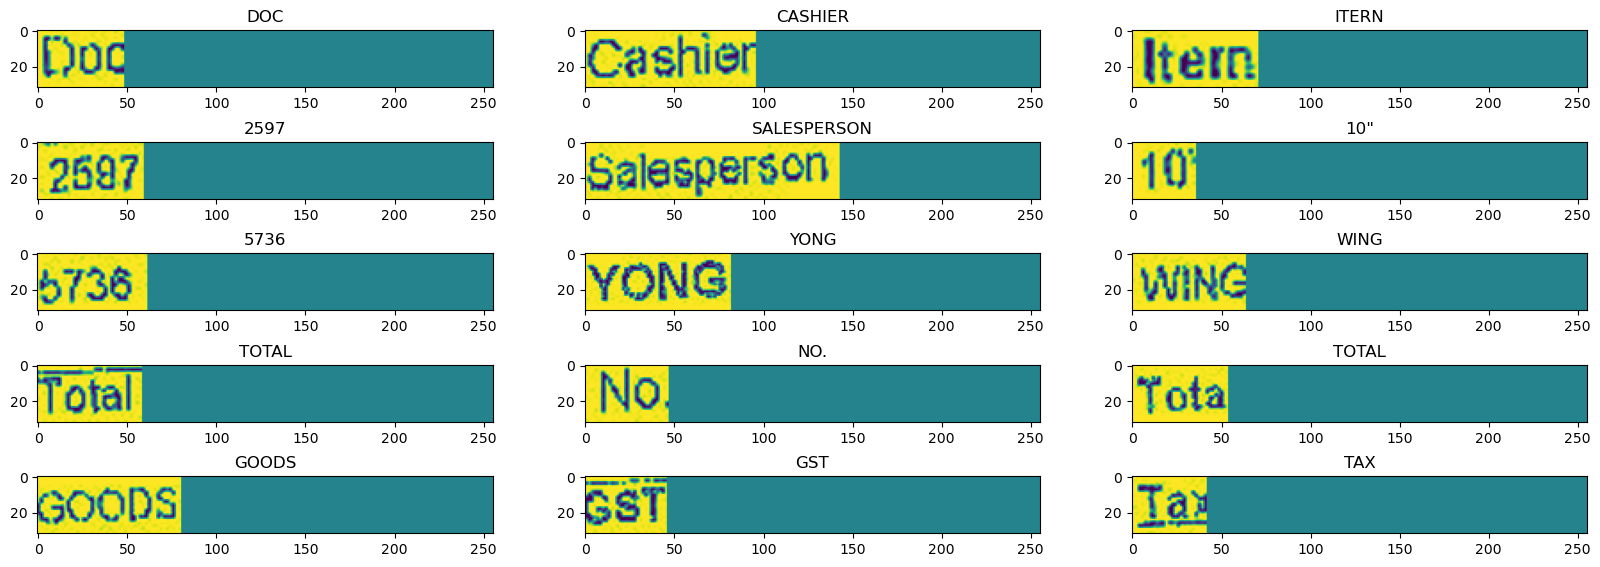

In [14]:
alphabets = ['ЁАБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЬЫЪЭЮЯ 0123456789!@№%?()-=+.,/«»:;~"<>[]', 'ABCDEFGHIJKLMNOPRSTUVWXYZ 0123456789!@№%?()-=+.,/«»:;~"<>[]']

def get_words_images_from_formatted(data_dict):
    # returns [[crop_box, word, script_idx], ...]
    
    cutted_boxes = []
    assert len(data_dict['boxes']) == len(data_dict['words'])
    for i, box in enumerate(data_dict['boxes']):
        if len(data_dict['words'][i]) > 30 or len(data_dict['words'][i]) < 2:
            continue
        cropped_box = data_dict['image'].copy()[box[1]:box[3], box[0]:box[2]]
        cropped_box = prepare_segment_for_recognition(cropped_box).squeeze()

        if all(char in alphabets[0] for char in data_dict['words'][i].upper()):
            script_idx = 0
        elif all(char in alphabets[1] for char in data_dict['words'][i].upper()):
            script_idx = 1
        else:
            continue
        cutted_boxes.append([cropped_box, data_dict['words'][i].upper(), script_idx])

    return cutted_boxes

full_dataset = []
crnn_train_dataset = []
crnn_eval_dataset = []


for example in train_dataset:
    segments = get_words_images_from_formatted(example)
    crnn_train_dataset.extend(segments)
    full_dataset.extend(segments)
    
for i, example in enumerate(train_sroie_examples):
    segments = get_words_images_from_formatted(example)
    crnn_train_dataset.extend(segments)
    full_dataset.extend(segments)
    
for example in val_dataset:
    segments = get_words_images_from_formatted(example)
    crnn_eval_dataset.extend(segments)
    full_dataset.extend(segments)
    
for i, example in enumerate(valid_sroie_examples):
    segments = get_words_images_from_formatted(example)
    crnn_eval_dataset.extend(segments)
    full_dataset.extend(segments)

import random
random.Random(59).shuffle(crnn_train_dataset)
random.Random(59).shuffle(crnn_eval_dataset)
random.Random(59).shuffle(full_dataset)

crnn_random_train_dataset = full_dataset[:len(crnn_train_dataset)]
crnn_random_eval_dataset = full_dataset[len(crnn_train_dataset):]

fig, axes = plt.subplots(ncols=3, nrows=5, figsize=(20, 7))
cropped_boxes_example = get_words_images_from_formatted(train_sroie_examples[48])

print(len(crnn_train_dataset), len(crnn_eval_dataset))
print(len(crnn_random_train_dataset), len(crnn_random_eval_dataset))

for i in range(15):
    image = cropped_boxes_example[i][0].squeeze()
    word = cropped_boxes_example[i][1]
    axes[i // 3, i % 3].imshow(image, vmin=0, vmax=255)
    axes[i // 3, i % 3].set_title(f'{word}')

In [15]:
from torchmetrics.text import CharErrorRate
from torchmetrics.classification import MulticlassF1Score
from copy import deepcopy
from torchinfo import summary


epochs = 200
batch_size = 500
early_stopping_patience = 50
img_size = (32, 256)
alphabets = ['ЁАБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЬЫЪЭЮЯ 0123456789!@№%?()-=+.,/«»:;~"<>[]', 'ABCDEFGHIJKLMNOPRSTUVWXYZ 0123456789!@№%?()-=+.,/«»:;~"<>[]']

train_dataset = my_OCRDataset(crnn_random_train_dataset, img_size, alphabets, batch_size, num_steps=75)
val_dataset = my_OCRDataset(crnn_random_eval_dataset, img_size, alphabets, batch_size, num_steps=15)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=12)

# device = 'cpu'
device = 'cuda:1'

model = MCRNN([len(a) for a in alphabets])
model.load_state_dict(torch.load('multilingual_crnn_0606l.pth', map_location=device))

optimizer = torch.optim.NAdam(model.parameters(), betas=(0.9, 0.999), lr=1e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=15)

summary(model, input_size=(batch_size, 1, img_size[0], img_size[1]), device=device, depth=3)

Layer (type:depth-idx)                        Output Shape              Param #
MCRNN                                         [500, 32, 68]             --
├─Sequential: 1-1                             [500, 256, 1, 32]         --
│    └─ResidualConvBlock2d: 2-1               [500, 16, 16, 128]        --
│    │    └─Conv2d: 3-1                       [500, 16, 32, 256]        160
│    │    └─LeakyReLU: 3-2                    [500, 16, 32, 256]        --
│    │    └─BatchNorm2d: 3-3                  [500, 16, 32, 256]        32
│    │    └─Conv2d: 3-4                       [500, 16, 32, 256]        2,320
│    │    └─LeakyReLU: 3-5                    [500, 16, 32, 256]        --
│    │    └─BatchNorm2d: 3-6                  [500, 16, 32, 256]        32
│    │    └─MaxPool2d: 3-7                    [500, 16, 16, 128]        --
│    │    └─Conv2d: 3-8                       [500, 16, 16, 128]        32
│    └─ResidualConvBlock2d: 2-2               [500, 32, 8, 128]         --
│    │    └─Conv

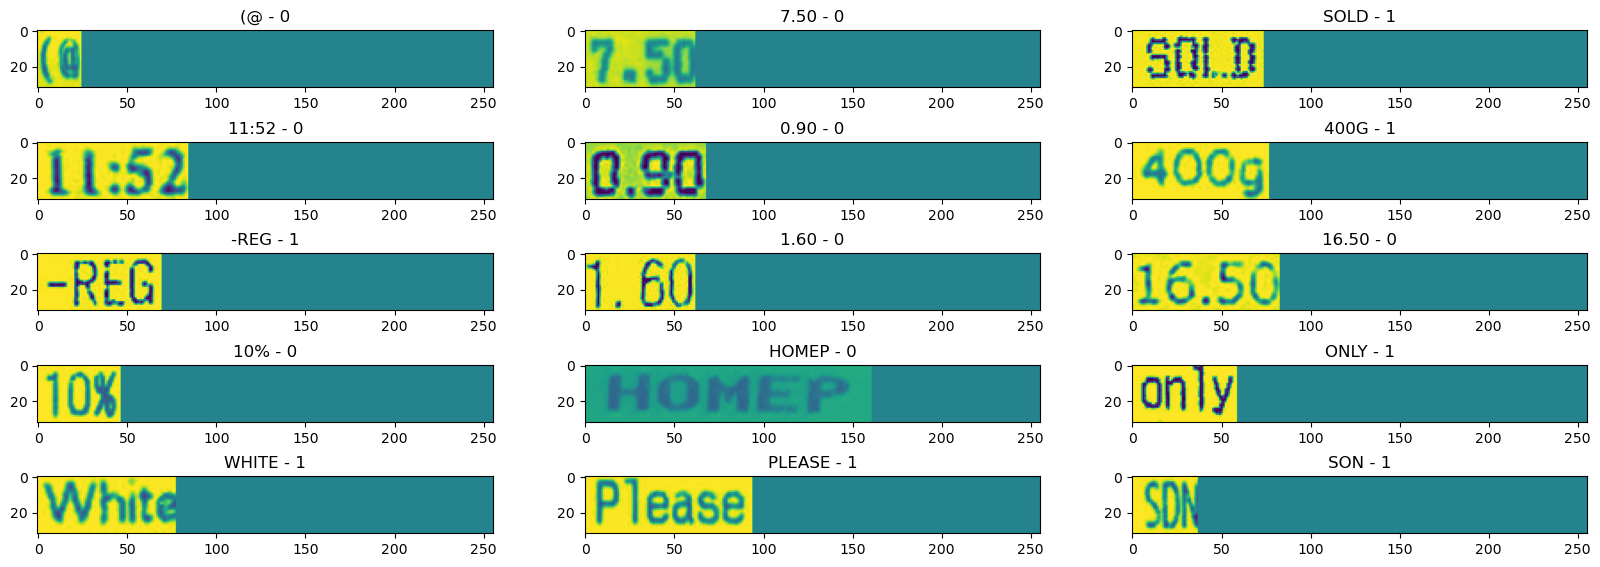

In [16]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=3, nrows=5, figsize=(20, 7))

x, y_text, y_script = next(iter(train_loader))

for i in range(15):
    axes[i // 3, i % 3].imshow(x[i, 0].numpy(), vmin=0, vmax=1)
    axes[i // 3, i % 3].set_title(f'{train_dataset.decode_target(y_text[i], y_script[i])} - {y_script[i]}')

# Train

In [17]:
torch.autograd.set_detect_anomaly(True)

model = model.to(device)
model.train()

criterion = multilingual_loss
cer_metric = CharErrorRate()
script_det_f1 = MulticlassF1Score(num_classes=len(alphabets)).to(device)

best_model_state = None
best_model_val_loss = torch.finfo(torch.float32).max

history = list()

outer_pbar = tqdm(range(epochs), desc='Epoch: 0, val_loss: ..., val_cer: ..., val_f1: ...')

for epoch in outer_pbar:
    
    train_ctc_loss = 0
    train_script_loss = 0
    val_ctc_loss = 0
    val_script_loss = 0

    train_cer = 0
    train_f1 = 0
    val_cer = 0
    val_f1 = 0

    pbar = tqdm(train_loader, leave=False, desc=f'0/{len(train_loader)}, train_loss: ..., train_cer: ...')

    for i, (x, text_y, script_y) in enumerate(train_loader):
        x = x.to(device)
        text_y = text_y.to(device)
        script_y = script_y.to(device)

        optimizer.zero_grad()
        pred_text_logits, pred_script_probs = model(x)

        decoded_pred = [train_dataset.decode_pred(pred_text_logits[i], aidx) for i, aidx in zip(torch.arange(script_y.shape[0]), script_y)]
        decoded_target = [train_dataset.decode_target(t, aidx) for t, aidx in zip(text_y, script_y)]

        # own ctc loss
        ctc_loss, script_loss = criterion(pred_text_logits, text_y, device, pred_script_probs, script_y, decoded_target,)
        if ctc_loss.item() > torch.Tensor([10**6]): ctc_loss = torch.Tensor([0]).to(device) # zero_infinity )))
        train_ctc_loss += ctc_loss.item()
        train_script_loss += script_loss.item()
        
        loss = ctc_loss + script_loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        cer = cer_metric(decoded_pred, decoded_target).item()
        f1 = script_det_f1(pred_script_probs, script_y).item()
        train_cer += cer
        train_f1 += f1

    for i, (x, text_y, script_y) in enumerate(val_loader):
        x = x.to(device)
        text_y = text_y.to(device)
        script_y = script_y.to(device)
        
        with torch.no_grad():
            pred_text_logits, pred_script_probs = model(x)

        decoded_pred = [train_dataset.decode_pred(pred_text_logits[i], aidx) for i, aidx in zip(torch.arange(script_y.shape[0]), script_y)]
        decoded_target = [train_dataset.decode_target(t, aidx) for t, aidx in zip(text_y, script_y)]
        
        ctc_loss, script_loss = criterion(pred_text_logits, text_y, device, pred_script_probs, script_y, decoded_target,)
        if ctc_loss.item() > torch.Tensor([10**6]): ctc_loss = torch.Tensor([0]).to(device) # )))
        
        val_ctc_loss += ctc_loss.item()
        val_script_loss += script_loss.item()

        val_cer += cer_metric(decoded_pred, decoded_target).item()
        val_f1 += script_det_f1(pred_script_probs, script_y).item()

    history.append([train_ctc_loss/len(train_loader), train_script_loss/len(train_loader), train_cer/len(train_loader), train_f1/len(train_loader), 
                    val_ctc_loss/len(val_loader), val_script_loss/len(val_loader), val_cer/len(val_loader), val_f1/len(val_loader)])

    if epoch > early_stopping_patience and (val_script_loss+val_ctc_loss) / len(val_loader) < np.array(history)[:, 4:6].sum(axis=1).min():
        best_model_state = model.state_dict()
    if epoch > early_stopping_patience and np.array(history)[:, 4:6].sum(axis=1).min() < np.array(history)[-early_stopping_patience:, 4:6].sum(axis=1).min():
        break

    outer_pbar.set_description(f'Epoch: {epoch}, val_loss: {round((val_ctc_loss + val_script_loss)/len(val_loader), 4)}, val_cer: {round(val_cer/len(val_loader), 4)}, val_f1: {round(val_f1/len(val_loader), 4)}')
    
if best_model_state is not None:
    model.load_state_dict(best_model_state)

history = np.array(history)

Epoch: 0, val_loss: ..., val_cer: ..., val_f1: ...:   0%|          | 0/200 [00:00<?, ?it/s]
0/206, train_loss: ..., train_cer: ...:   0%|          | 0/206 [00:00<?, ?it/s]

Epoch: 0, val_loss: 1.2271, val_cer: 0.3027, val_f1: 0.6265:   0%|          | 1/200 [01:46<5:51:43, 106.05s/it]

0/206, train_loss: ..., train_cer: ...:   0%|          | 0/206 [00:00<?, ?it/s]
Epoch: 1, val_loss: 1.0216, val_cer: 0.2867, val_f1: 0.638:   1%|          | 2/200 [03:32<5:50:20, 106.17s/it] 
0/206, train_loss: ..., train_cer: ...:   0%|          | 0/206 [00:00<?, ?it/s]

Epoch: 2, val_loss: 0.9025, val_cer: 0.2798, val_f1: 0.6382:   2%|▏         | 3/200 [05:18<5:48:24, 106.12s/it]

0/206, train_loss: ..., train_cer: ...:   0%|          | 0/206 [00:00<?, ?it/s]
Epoch: 3, val_loss: 0.8656, val_cer: 0.2636, val_f1: 0.6696:   2%|▏         | 4/200 [07:04<5:46:41, 106.13s/it]
0/206, train_loss: ..., train_cer: ...:   0%|          | 0/206 [00:00<?, ?it/s]

Epoch: 4, val_loss: 0.8346, val_cer: 0.2621, val_f1: 0.

In [18]:
min(np.array(history)[:, 6]) # best cer 0.07 on rus receipts only, 0.209 with sroie added

0.21363573893904686

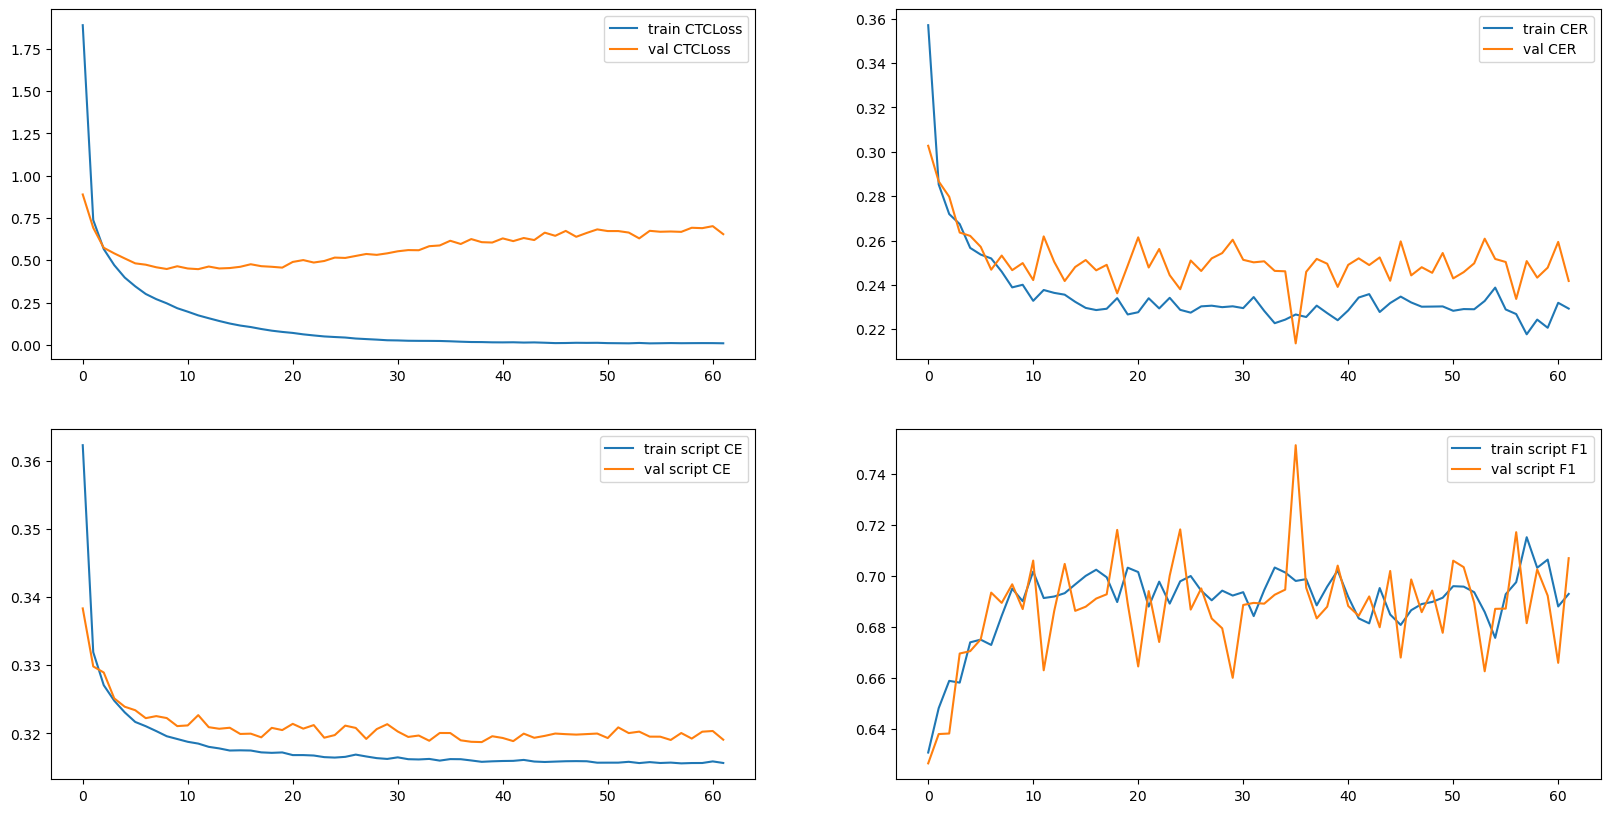

In [19]:
import matplotlib.pyplot as plt

history = np.array(history)

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 10))

axes[0, 0].plot(history[:, 0], label='train CTCLoss')
axes[0, 0].plot(history[:, 4], label='val CTCLoss')
# axes[0].set_ylim(min(train_loss_history)*0.75, max(train_loss_history[10:]))
axes[0, 0].legend()

axes[0, 1].plot(history[:, 2], label='train CER')
axes[0, 1].plot(history[:, 6], label='val CER')
# axes[1].set_ylim(min(train_cer_history)*0.75, max(train_cer_history[10:]))
axes[0, 1].legend()

axes[1, 0].plot(history[:, 1], label='train script CE')
axes[1, 0].plot(history[:, 5], label='val script CE')
axes[1, 0].legend()

axes[1, 1].plot(history[:, 3], label='train script F1')
axes[1, 1].plot(history[:, 7], label='val script F1')
axes[1, 1].legend()

In [20]:
torch.save(model.state_dict(), 'multilingual_crnn_RS_ce213_0807l.pth')

In [ ]:
import os
import signal

os.kill(os.getpid(), signal.SIGTERM)